# Image reconstruction in X-ray tomography

#### Package imports

In [311]:
import numpy as np
import scipy
import time
import scipy.io
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.set_cmap('terrain')
np.random.seed(0)

<Figure size 432x288 with 0 Axes>

In [346]:
H = scipy.io.loadmat('data/H.mat')['H']
x = scipy.io.loadmat('data/x.mat')['x']
lambda_=0.13
delta=0.02
M,N = H.shape

In [313]:
y = (H.dot(x).reshape(16200) + np.random.normal(0,1,M))

####  Signal x

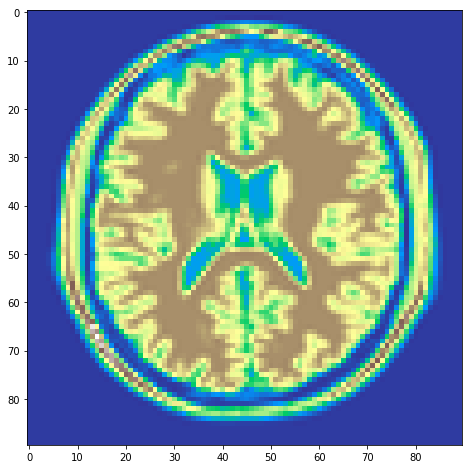

In [314]:
plt.figure(figsize=(8,8))
plt.imshow(x.reshape(90,90,order='F'))

#### Sinogram of the mesured signal y 

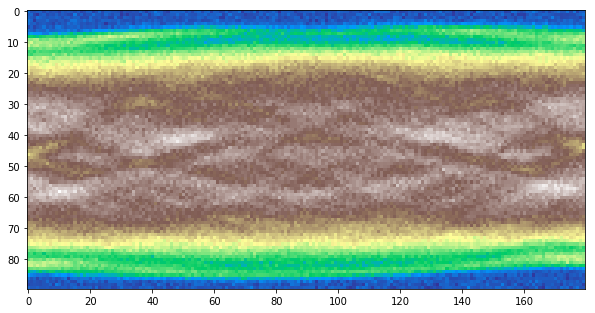

In [315]:
plt.figure(figsize=(10,10))
plt.imshow(y.reshape(90,180,order='F'))

# 2 - Optimization problem

#### 1 - Gradient operator

In [291]:
G = scipy.io.loadmat('data/G.mat')['G']

#### 2 - Gradient explicitation

The function $f$ is differentiable over $R^N$ as a sum of 2 differentiable functions:

$$\nabla f = H^THx + H^Ty + \frac{\lambda}{\delta^2}G^T(\frac{[Gx]^{(i)}}{\sqrt{1 + (\frac{[Gx]^{(i)}}{\delta})^2}})_{i\in 1,..,2N}$$ 


where $G_i$ denotes the $i^{th}$ line of the matrice G.


In [292]:
def Grad_f(x, lambda_=lambda_, delta=delta):   
    return H.T.dot(H.dot(x)-y) + lambda_/(delta**2)* G.T.dot((G.dot(x)/np.sqrt(1+(G.dot(x)/delta)**2)))

#### 3 - Lipschitz constant

We have that $\forall (x,y) \in \mathbb{R}^{N\times2}, (\lambda,\delta) \in \mathbb{R}^{+^2} $ 

$$ \|\nabla f(x) - \nabla f(y) = \| H^TH(x-y) + \frac{\lambda}{\delta^2}G^T(\frac{[G(x-y)]^{(i)}}{\varphi([G(x-y)]^{(i)})}) \|$$

Hence, the triangular inequality and the definition of the norm over $\mathbb{R}^{N}$ and $\mathbb{R}^{N\times N}$ gives us:

$$ \|\nabla f(x) - \nabla f(y) \| \leq \| H^TH(x-y) \| +  \frac{\lambda}{\delta^2}\|G^T \| \|(\frac{[G(x-y)]^{(i)}}{\varphi([G(x-y)]^{(i)})} )\|$$

By definition of $\varphi$, $\forall x \in R^N, \|\frac{x}{\varphi(x)}\| < \|x\|$ Hence, 

$$ \|\nabla f(x) - \nabla f(y) \| \leq \| H^TH \| \|(x-y) \| +  \frac{\lambda}{\delta^2}\|G^T \| \|G(x-y)\|$$

$$ \|\nabla f(x) - \nabla f(y) \| \leq \| H^TH \| \|(x-y) \| +  \frac{\lambda}{\delta^2}\|G^T \| \|G\|\|(x-y)\|$$

Finally, given $\|H^T\| = \|H\|$

$$ \|\nabla f(x) - \nabla f(y) \| \leq (\|H\|^2+  \frac{\lambda}{\delta^2}\|G\|^2)\|(x-y)\|$$


In [293]:
nu = scipy.sparse.linalg.svds(H)[1][-1]**2 + (lambda_/delta**2)*scipy.sparse.linalg.svds(G)[1][-1]**2
print(nu)

18092.773276864737


# Gradient descent Algorithm 

In [294]:
x_0 = np.zeros(N)

In [296]:
def Gradient_descent(x_0=np.zeros(N) ,gamma=1/nu ,tol=1e-4):
    tolerance=1
    x_n = x_0
    count=0
    times={}
    times[0]= np.linalg.norm(Grad_f(x_n, lambda_, delta))
    start=time.time()
    while tolerance>np.sqrt(N)*tol:
        
        #counter to follow convergence
        if count%100==0:
            print(count,tolerance,'\n')
         
        #application of gradient operator 
        x_n1 = x_n - gamma*Grad_f(x_n, lambda_, delta)
        tolerance = np.linalg.norm(Grad_f(x_n, lambda_, delta))
        
        #iteration of counters
        x_n = x_n1
        count+=1
        
        #saving times of convergence
        times[time.time()-start]=tolerance
        
    return(x_n, times)

sol_gd, tempo_gradient_descent = Gradient_descent(x_0=x_0)       

0 1 

100 516.4329972841346 

200 149.94706128352686 

300 73.99408341684845 

400 45.07184113573094 

500 29.93927860317269 

600 20.74818846386858 

700 14.745966231936134 

800 10.703168674436156 

900 7.898179000441491 

1000 5.897533841390967 

1100 4.451635525391294 

1200 3.398178163390073 

1300 2.623939828727007 

1400 2.0490717483716505 

1500 1.6173329204253124 

1600 1.2891725418219107 

1700 1.0367537879406448 

1800 0.8403939149333113 

1900 0.6860571291904375 

2000 0.5636190269897903 

2100 0.46567991112093365 

2200 0.38675747966337437 

2300 0.3227364085762089 

2400 0.27049003736324917 

2500 0.22761714347766873 

2600 0.19225609477946112 

2700 0.16295158651881783 

2800 0.13855762486978906 

2900 0.11816589859254281 

3000 0.10105222778898595 

3100 0.08663608887669487 

3200 0.07444973602599789 

3300 0.06411445577628064 

3400 0.05532218237633962 

3500 0.04782117942016089 

3600 0.041404830079120235 

3700 0.03590281944638094 

3800 0.031174167959647746 

3900 0

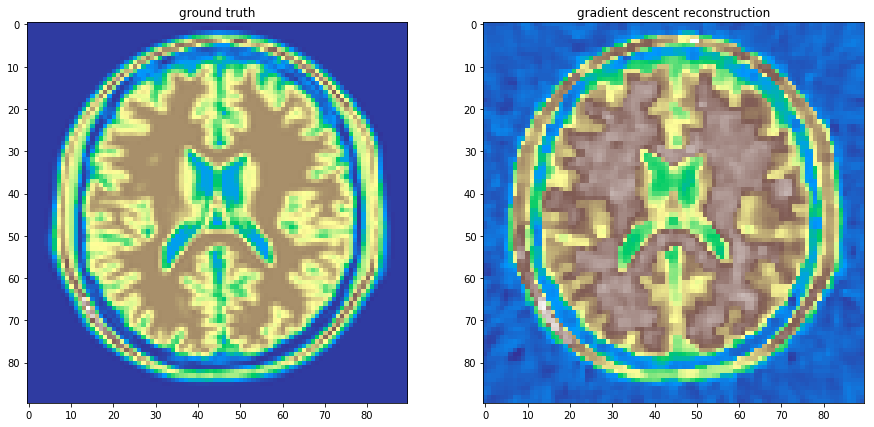

In [333]:
fig, a = plt.subplots(1,2,figsize=(15,15))
a[0].set_title('ground truth')
a[0].imshow(x.reshape(90,90,order='F'))
a[1].set_title('gradient descent reconstruction')
a[1].imshow(sol_gd.reshape(90,90,order='F'))

# MM Algorithm



We have that $f$ is twice differentiable over $\mathbb{R}^{N}$. Then we have the general result, given that f is twice differentiable over $\mathbb{R}^N$, that $\forall A$ s.t $A − \nabla^2f(x)$ is positive semidefinite:

$$ \forall \in \mathbb{R},  f(x) \leq f(y) + \nabla{f}(y)^T(x-y) + \frac{1}{2}(x-y)^TA(x-y)$$

First the hessian in $x \in \mathbb{R}^{N}$ of $f_1(x) = \|Hx-y\|^2$ is $H^TH$, hence we have the following result: 

$$  \forall \in \mathbb{R},  f_1(x) \leq f_1(y) + \nabla{f_1}(y)^T(x-y) + \frac{1}{2}(x-y)^TH^TH(x-y)$$

We note also that the function $f_2 = \lambda\sum\psi$ is an even differentiable function, and that $\forall u \in \mathbb{R}:$
> i) $ \psi(u) = \psi(|u|) $

> ii) $ \psi(\sqrt(.))= \sqrt{1 + \frac{|.|}{\delta^2}}$ is concave

> iii) $ \frac{\partial\psi(u)}{\partial u} = \frac{u}{\delta\sqrt{1 + (\frac{u}{\delta})^2}} ≥ 0$

> iv) $ \frac{1}{\delta\sqrt{1 + (\frac{u}{\delta})^2}} \longrightarrow \delta^{-1} \in R $


Here, since $\nabla^2f_2(x) ≤ \frac{\lambda}{\delta^2}G^T D([Gx]^{(i)})G$ with $D([Gx]^{(i)}) = Diag(\frac{\psi'[Gx]^{(i)}}{[Gx]^{(i)}})$


Hence, a majorant function of $f$ is the following function $h$ taken as the sum of the majorant function:

$$ \forall x \in \mathbb{R}^{N}, f(x) \leq f(y) + \nabla{f}(y)^T(x-y) + \frac{1}{2}(x-y)^TA(x)(x-y)$$

$$ \text{with} \space \space   A(x)=H^TH + \frac{\lambda}{\delta^2}G^T D([Gx]^{(i)})G$$

In [334]:
from scipy.sparse.linalg import LinearOperator

#def Curv(x,v):
#    PSI = 1/np.sqrt(1+(G.dot(x)/delta)**2)
#    D = scipy.sparse.diags(PSI).tocsc()
#    return H.T.dot(H.dot(v)) + (lambda_/delta**2)*G.T.dot(D.dot(G.dot(v)))

def Curvature(x, lambda_=lambda_, delta=delta):
    PSI = 1/np.sqrt(1+(G.dot(x)/delta)**2)
    D = scipy.sparse.diags(PSI).tocsc()
    Mat = lambda v: H.T.dot(H.dot(v)) + (lambda_/delta**2)*G.T.dot(D.dot(G.dot(v)))
    LO = LinearOperator((N,N), matvec=Mat)
    LO.rmatvec = Mat
    return LO

 

In [335]:
def MM(x_0=np.zeros(N) ,theta=1 ,tol=1e-4):
    tolerance=1
    x_n = x_0
    count=0
    times={}
    times[0]= np.linalg.norm(Grad_f(x_n,lambda_=lambda_, delta=delta))
    start=time.time()
    while tolerance>np.sqrt(N)*tol:
        if count%10==0:
            print(count,tolerance,'\n')
        
        #scipy.sparse.linalg.bicg(Curvature(x_n),Grad_f(x_n)) 
        it = scipy.sparse.linalg.bicg(Curvature(x_n, lambda_=lambda_, delta=delta),Grad_f(x_n, lambda_=lambda_, delta=delta),maxiter=500)[0]
        x_n1 = x_n - theta*it
        tolerance = np.linalg.norm(Grad_f(x_n,lambda_=lambda_, delta=delta))
        
        #iteration of counters
        x_n = x_n1
        count+=1
        
        #saving times of convergence
        times[time.time()-start]=tolerance
        
    return(x_n,times)

sol2, tempo_MM = MM()       

0 1 

10 21.087232655671375 

20 2.4849160884707517 

30 0.5140052031817135 

40 0.152256911708591 

50 0.05403318362786328 

60 0.020925579748455686 



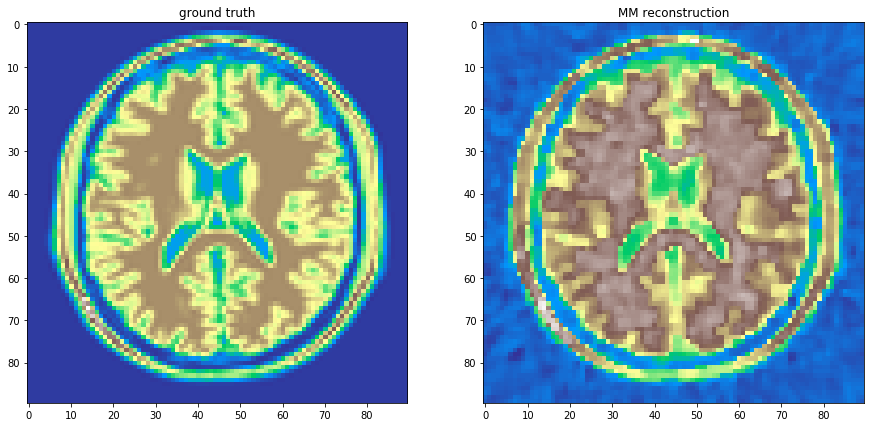

In [336]:
fig, a = plt.subplots(1,2,figsize=(15,15))
a[0].set_title('ground truth')
a[0].imshow(x.reshape(90,90,order='F'))
a[1].set_title('MM reconstruction')
a[1].imshow(sol2.reshape(90,90,order='F'))

# 3MG Algorithm

The MM quadratic algorithm can be accelerated by using a subspace strategy. Here, we will focus on the so-called 3MG (MM Memory Gradient) approach which consists in defining the iterate $x_{k+1}$ as the minimizer of the quadratic majorant function at $x_k$ within a subspace spanned by the following directions :

$$ \forall k \in \mathbb{N}, D_k = [−\nabla f(x_k) | x_k −x_{k−1}]$$

An iterate of 3MG is then: 

$$\forall k \in \mathbb{N}, x_{k+1}= x_k + D_k u_k, \space \text{where}\space \space  u_k = −(D_k^TA(x_k)D_k)^†(D_k^T\nabla f(x_k))$$

Here, we explicit the vector $u_k$ as: 

$$ u_k = −(D_k^T(H^TH + \frac{\lambda}{\delta^2}G^T D([Gx]^{(i)})G)D_k)^†(D_k^T\nabla f(x_k))$$

or even, in a computationnaly more friendly fashion: 

$$ u_k = −[(HD_k)^T(HD_k) + \frac{\lambda}{\delta^2}(GD_k)^T D([Gx]^{(i)})(GD_k))^†(D_k^T\nabla f(x_k)]$$

In [337]:
def Three_MG(x_0=np.zeros(N),tol=1e-4, lambda_=0.1, delta=0.02):
    tolerance=1
    x_n = x_0
    count=0
    times={}
    times[0]= np.linalg.norm(Grad_f(x_n,lambda_=lambda_, delta=delta))
    start=time.time()
    while tolerance>np.sqrt(N)*tol:
        
        if count%10==0:
            print(count,tolerance,'\n')
            
        if count==0:
            D_n = -Grad_f(x_n, lambda_=lambda_, delta=delta)
            
            PSI = 1/np.sqrt(1+(G.dot(x_n)/delta)**2)
            D = scipy.sparse.diags(PSI).tocsc()
            Curv = (H@D_n).T.dot(H@D_n) + (lambda_/delta**2)*(G@D_n).T.dot(D.dot(G@D_n))
            u_n = - (D_n.T.dot(Grad_f(x_n,lambda_=lambda_, delta=delta)))/Curv

            x_n_1 = x_n
            x_n1 = x_n + D_n.dot(u_n)                                        
            tolerance = np.linalg.norm(Grad_f(x_n,lambda_=lambda_, delta=delta))
            
        else:

            D_n = np.vstack((-Grad_f(x_n,lambda_=lambda_, delta=delta),x_n-x_n_1)).T

            PSI = 1/np.sqrt(1+(G.dot(x_n)/delta)**2)
            D = scipy.sparse.diags(PSI).tocsc()
            Curv = (H@D_n).T.dot(H@D_n) + (lambda_/delta**2)*(G@D_n).T.dot(D.dot(G@D_n))
            u_n = - scipy.linalg.pinv(Curv)@(D_n.T.dot(Grad_f(x_n,lambda_=lambda_, delta=delta)))

            x_n_1 = x_n
            x_n1 = x_n + D_n.dot(u_n)                                        
            tolerance = np.linalg.norm(Grad_f(x_n,lambda_=lambda_, delta=delta))

        #iteration of counters
        x_n = x_n1
        count+=1
        
        #saving times of convergence
        times[time.time()-start]=tolerance
        
    return(x_n, times)

sol_MG, tempo_MG = Three_MG()       


0 1 

10 844.0296418043586 

20 183.2954013612083 

30 81.33026243518641 

40 32.108691373989544 

50 13.93988376070804 

60 6.1412475772271256 

70 3.0930466451020315 

80 1.2812036292443119 

90 0.6180848488414079 

100 0.30459935541506705 

110 0.14317822242131545 

120 0.07349908519249465 

130 0.03688873741721967 

140 0.017584437334047888 



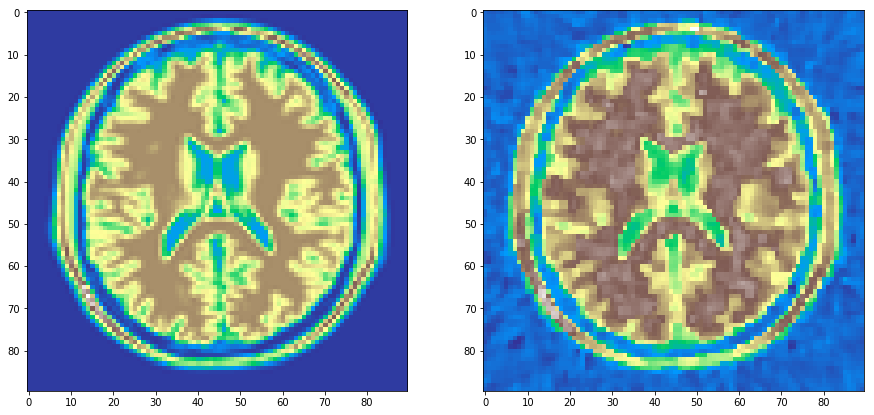

In [338]:
fig, a = plt.subplots(1,2,figsize=(15,15))
a[0].imshow(x.reshape(90,90,order='F'))
a[1].imshow(sol_MG.reshape(90,90,order='F'))

# Block-coordinate Algorithm

Another acceleration strategy consists in applying a block alternation technique. The vector x is divided into J ≥ 1 blocks, with size 1 ≤ $N_j$ ≤ N. At each iteration k ∈ N, a block index j ⊂ {1,...,J} is chosen, and the corresponding components of x, denoted x(j), are updated, according to a MM quadratic rule. Here, we will assume that the blocks are selected in a cyclic manner, that is,

$$\forall k \in \mathbb{N},  j=mod(k−1,J)+1.$$

For a given block index j, the corresponding pixel indexes are updated in the image :

$$ n \in \mathbb{J}_j =\{N_j(j−1)+1,...,jN_j\}.$$

In [339]:
def Curvature(x,j,N_j,G,H):
    
    x = x[int(N_j*(j-1)):int(j*N_j)]
    G = G[:,int(N_j*(j-1)):int(j*N_j)]
    H = H[:,int(N_j*(j-1)):int(j*N_j)]
    PSI = 1/np.sqrt(1+(G.dot(x)/delta)**2)
    D = scipy.sparse.diags(PSI).tocsc()
    Mat = lambda v: H.T.dot(H.dot(v)) + (lambda_/delta**2)*G.T.dot(D.dot(G.dot(v)))
    LO = LinearOperator((int(N_j),int(N_j)), matvec=Mat)
    LO.rmatvec = Mat
    return LO

def Grad_f_j(x,j,N_j):   
    return H.T.dot(H.dot(x)-y)[int(N_j*(j-1)):int(j*N_j)] + lambda_/(delta**2)* G.T.dot((G.dot(x)/np.sqrt(1+(G.dot(x)/delta)**2)))[int(N_j*(j-1)):int(j*N_j)]


def Block_Coordinate_MM_quadratic(x_0=np.zeros(N), K=3, theta=1, tol=1e-4):
    tolerance=1
    x_n = x_0
    count=0
    N_j = N/K
    times={}
    times[0]= np.linalg.norm(Grad_f(x_n,lambda_=lambda_, delta=delta))
    start=time.time()
    while tolerance>np.sqrt(N)*tol:
        j= count%K + 1
        
        if count%10==0:
            print(count, tolerance, '\n')
        
        it = scipy.sparse.linalg.bicg(Curvature(x_n,j,N_j,G,H),Grad_f_j(x_n,j,N_j),maxiter=500)[0]
        x_n1 = np.copy(x_n)
        x_n1[int(N_j*(j-1)):int(j*N_j)] = x_n[int(N_j*(j-1)):int(j*N_j)] - theta*it
        
        #iteration of counters
        x_n = x_n1
        tolerance = np.linalg.norm(Grad_f(x_n,lambda_=lambda_, delta=delta))
        count+=1
        
        #saving times of convergence
        times[time.time()-start]=tolerance
        
    return(x_n,times)

solBlock, tempo_block = Block_Coordinate_MM_quadratic() 


0 1 

10 5945.527040481743 

20 2172.319838481362 

30 798.1420636873669 

40 136.11412394555984 

50 27.8587217638637 

60 6.767455925370311 

70 3.04145347153032 

80 1.4251452422856867 

90 0.7695986846147046 

100 0.46301674650290486 

110 0.29134799295744185 

120 0.18629424773740855 

130 0.1241073234469968 

140 0.08591442377616233 

150 0.058674365487560026 

160 0.04175040470043991 

170 0.030308215624528373 

180 0.02131147342872052 

190 0.015796590070077485 

200 0.011798751448609925 



#### Test of Block- coordinate update for K={1,2,3,5,6,9}

In [408]:
solBlock1, tempo_block1 = Block_Coordinate_MM_quadratic(K=1) 
solBlock2, tempo_block2 = Block_Coordinate_MM_quadratic(K=2) 
solBlock3, tempo_block3 = Block_Coordinate_MM_quadratic(K=3) 
solBlock5, tempo_block5 = Block_Coordinate_MM_quadratic(K=5) 
solBlock6, tempo_block6 = Block_Coordinate_MM_quadratic(K=6) 
solBlock9, tempo_block9 = Block_Coordinate_MM_quadratic(K=9) 

0 1 

10 1.3311949214595542 

20 0.0309479845571647 

0 1 

10 4921.542941442583 

20 991.8694209496773 

30 91.20983123495499 

40 5.00441186455021 

50 0.26687645039540603 

60 0.01431177326754701 

0 1 

10 7099.154224306835 

20 2643.584110430301 

30 837.3152457642 

40 123.98395107802997 

50 22.895869846988933 

60 3.9397854085310935 

70 0.8634945283828002 

80 0.10481126771877244 

90 0.018482166975629155 

0 1 

10 34147.21712585343 

20 8825.3437916685 

30 3452.241739755582 

40 1422.3776442079668 

50 494.20572660540904 

60 181.34296486875093 

70 65.96169289424287 

80 25.0343691685379 

90 10.374006832127083 

100 4.355002449307651 

110 1.7541510181644822 

120 0.6754552420288266 

130 0.25405441350270375 

140 0.09645326672810467 

150 0.03813668144406168 

160 0.015913099637472207 

0 1 

10 32100.38482381726 

20 6432.201935998866 

30 4921.809479614143 

40 1643.6461158231941 

50 1138.5455793705478 

60 422.4935242332559 

70 166.55209080029502 

80 74.42479902873

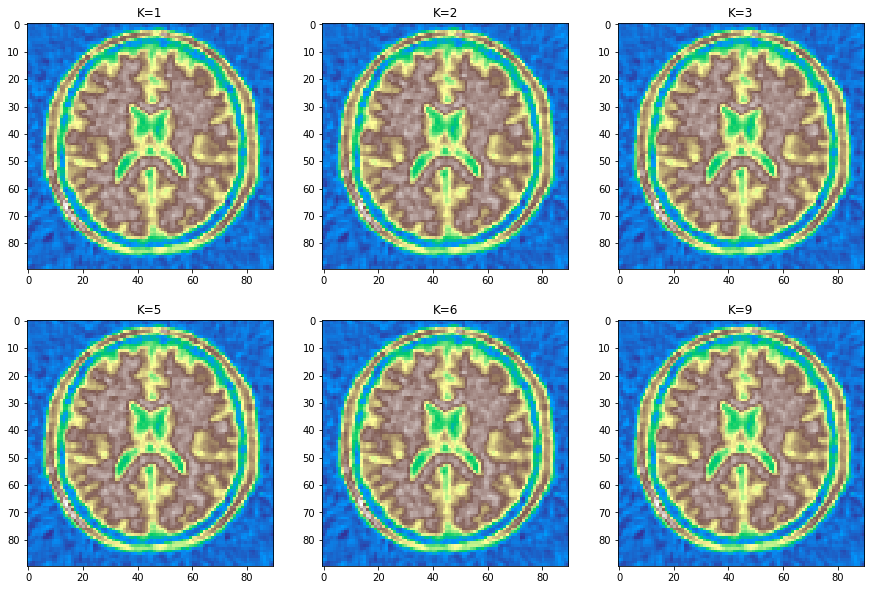

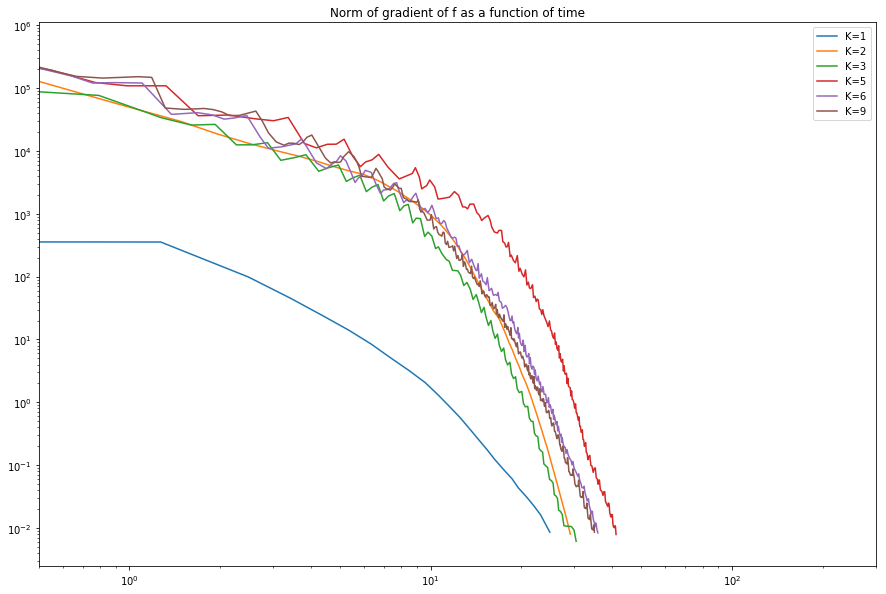

In [414]:
fig, a = plt.subplots(2,3,figsize=(15,10))
a[0,0].set_title('K=1')
a[0,0].imshow(solBlock1.reshape(90,90,order='F'))
a[0,1].set_title('K=2')
a[0,1].imshow(solBlock2.reshape(90,90,order='F'))
a[0,2].set_title('K=3')
a[0,2].imshow(solBlock3.reshape(90,90,order='F'))
a[1,0].set_title('K=5')
a[1,0].imshow(solBlock5.reshape(90,90,order='F'))
a[1,1].set_title('K=6')
a[1,1].imshow(solBlock6.reshape(90,90,order='F'))
a[1,2].set_title('K=9')
a[1,2].imshow(solBlock9.reshape(90,90,order='F'))

plt.figure(figsize=(15,10))
time1, tol1  = zip(*sorted(tempo_block1.items()))
time2, tol2  = zip(*sorted(tempo_block2.items()))
time3, tol3  = zip(*sorted(tempo_block3.items()))
time5, tol5  = zip(*sorted(tempo_block5.items()))
time6, tol6  = zip(*sorted(tempo_block6.items()))
time9, tol9  = zip(*sorted(tempo_block9.items()))

plt.loglog(time1,tol1, label='K=1')
plt.loglog(time2,tol2, label='K=2')
plt.loglog(time3,tol3, label='K=3')
plt.loglog(time5,tol5, label='K=5')
plt.loglog(time6,tol6, label='K=6')
plt.loglog(time9,tol9, label='K=9')
plt.xlim([0.5,300])
plt.title('Norm of gradient of f as a function of time')
plt.legend()
plt.show()

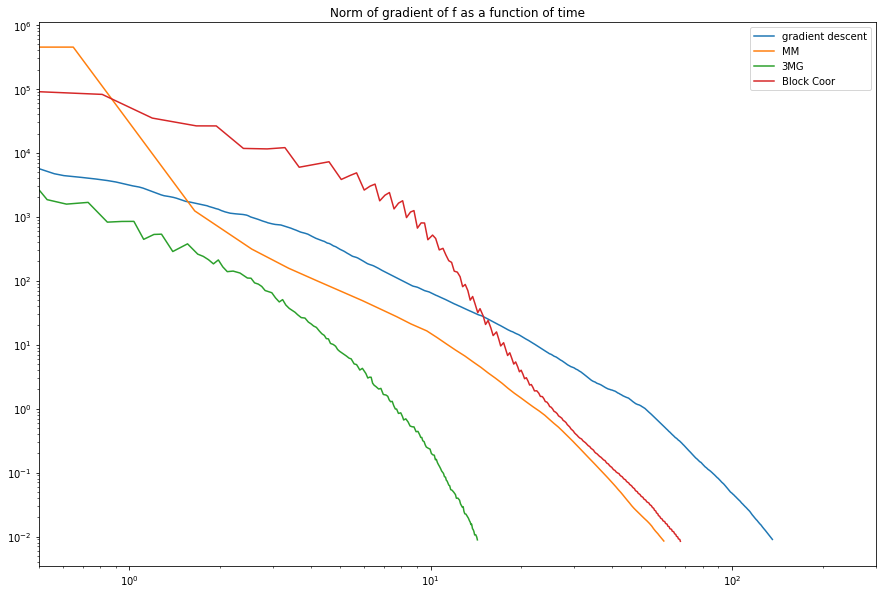

In [350]:
plt.figure(figsize=(15,10))
time_gd, tol_gd  = zip(*sorted(tempo_gradient_descent.items()))
time_mm, tol_mm  = zip(*sorted(tempo_MM.items()))
time_mg, tol_mg  = zip(*sorted(tempo_MG.items()))
time_b, tol_b  = zip(*sorted(tempo_block.items()))
plt.loglog(time_gd,tol_gd, label='gradient descent')
plt.loglog(time_mm,tol_mm, label='MM')
plt.loglog(time_mg,tol_mg, label='3MG')
plt.loglog(time_b,tol_b, label='Block Coor')
plt.xlim([0.5,300])
plt.title('Norm of gradient of f as a function of time')
plt.legend()
plt.show()

**Observation**: Although the different algorithm started from the same original point $x_0 = 0_{R^N}$, they behaved differently in the very first iterations. Note here that the axis are in log-scale. 

> It is interting to see that the **Block_coordinate** techniques initially perform poorly compared to the other since the update is performed only on a subset of the indices of the vector x. However, this strategy accelerate the convergence after a while, making it a more efficient strategy that the gradient descent.

> **MM algorithm** curve shows that every update of the vector take a longer time due to the inversion system that needs to be computed, however every update is relevant thanks to the alternating minimization step.

> **3MG algorithm** performs best in terms of time due to the restriction of the update along the specified directions [$\nabla f(x_n)|x_n - x_{n-1}$]

#### Grid search of optimal parameters ($\lambda,\delta$)

In this section, we use the 3MG algorithm to search for the best reconstruction estimate in the space of paramters $(\lambda,\delta) \in [0.01,10]\times[0.001,0.1]$

In [352]:
def SNR(estimate, signal):
    return 10*np.log10(np.linalg.norm(signal)**2/np.linalg.norm(signal - estimate)**2)

In [415]:
lambdas = np.logspace(-0.1,1,4)
deltas = np.logspace(-3,-1,4)
SNRS=[]
for lambda_ in lambdas:
    for delta in deltas:
        print(lambda_, delta, '\n')
        sol_MG, tempo_MG = Three_MG(lambda_ = lambda_, delta=delta,tol=1e-2)    
        SNRS.append(SNR(sol_MG, x)) 
        
X, Y = np.meshgrid(lambdas, deltas)
Z = np.array(SNRS)
Z = Z.reshape(X.shape)

0.7943282347242815 0.001 

0 1 

10 74233.33601802163 

20 74279.88779172268 

30 47672.94203834903 

40 27052.27623020575 

50 16326.375891909265 

60 15418.17389732455 

70 13075.790274622004 

80 10777.44236011789 

90 8655.321967880416 

100 7068.950377226582 

110 5489.9691431278015 

120 4667.776426285062 

130 3885.630955344816 

140 3003.8934032068646 

150 2511.457719844562 

160 2036.0784440712848 

170 1632.2424610881515 

180 1318.3733761927742 

190 1122.2826463530891 

200 974.4710511813914 

210 809.369323095298 

220 680.0041787891971 

230 582.0352891417447 

240 504.98751625535004 

250 490.37072122106775 

260 438.47196708539076 

270 394.0594460026351 

280 346.48453286685145 

290 323.85547928630353 

300 301.6674962526152 

310 270.15162360289287 

320 249.02492028330192 

330 235.4961541389295 

340 223.71869423016147 

350 207.88188245108378 

360 196.45032427448996 

370 185.51480070337377 

380 173.13771943091186 

390 168.1140459279273 

400 161.0422068179893

600 164.82266230296253 

610 159.16021037102772 

620 153.74591200791875 

630 148.6235468010668 

640 143.92950207104306 

650 139.66100430535388 

660 135.67201024523135 

670 131.76091559959573 

680 127.71497720047742 

690 123.63641382614897 

700 119.80096254131134 

710 116.19298386809234 

720 112.71199027829812 

730 109.31703360032924 

740 106.06098324736786 

750 102.99158632388912 

760 100.15006953001897 

770 97.54076097304119 

780 95.07722516569699 

790 92.64126439411632 

800 90.19144424113304 

810 87.784556669137 

820 85.48249978081682 

830 83.3010060295757 

840 81.23624649526195 

850 79.27530039928031 

860 77.40085497325663 

870 75.60455120004036 

880 73.88370360773193 

890 72.22447289189255 

900 70.60625360376218 

910 69.01601737585642 

920 67.45044201407087 

930 65.91024263550113 

940 64.39486547294764 

950 62.903354829525796 

960 61.437721169574104 

970 60.00453870901076 

980 58.63681685084962 

990 57.515051427317374 

1000 56.41593502267746 


500 1.0027755529049793 

510 0.9331268287269897 

1.8478497974222912 0.021544346900318832 

0 1 

10 1052.5211313544755 

20 128.40547216104665 

30 26.14702640236497 

40 8.636705135946883 

50 3.3603490803712313 

60 1.5285555663359167 

1.8478497974222912 0.1 

0 1 

10 459.0826283953076 

20 80.2859092353105 

30 15.171813574780142 

40 4.9190241097917164 

50 1.2194552239279597 

4.298662347082278 0.001 

0 1 

10 120777.17191155323 

20 98370.69328896393 

30 82926.88106584955 

40 68672.07656032951 

50 59202.625133020745 

60 50127.4641061131 

70 45333.722153830335 

80 38543.28251153713 

90 40368.17694749095 

100 36206.25764127397 

110 34622.79023219016 

120 31109.676915358203 

130 32105.914466214814 

140 26885.563071043765 

150 22504.16373029359 

160 21695.588751422707 

170 17744.36370614731 

180 15353.96131000213 

190 14832.116163229306 

200 12288.888994321984 

210 10048.823750157644 

220 8654.533235460734 

230 7684.927084415811 

240 7093.715847894686 

250 

3130 4.177423124053305 

3140 4.133584642633419 

3150 4.090352189942912 

3160 4.04771431015162 

3170 4.005659863834008 

3180 3.9641780156525015 

3190 3.9232582232499933 

3200 3.882890226376336 

3210 3.843064036038565 

3220 3.803769924641841 

3230 3.764998416674688 

3240 3.7267402791324287 

3250 3.68898651331788 

3260 3.6517283455116107 

3270 3.614957220101261 

3280 3.578664791075863 

3290 3.542842914887134 

3300 3.5074836437266934 

3310 3.4725792182426787 

3320 3.438122061649117 

3330 3.4041047729369875 

3340 3.3705201217686427 

3350 3.3373610421571964 

3360 3.3046206271193594 

3370 3.2722921237979916 

3380 3.2403689283044668 

3390 3.208844580613827 

3400 3.177712760788376 

3410 3.1469672836420917 

3420 3.116602095273007 

3430 3.0866112687063922 

3440 3.0569889999341684 

3450 3.0277296042794086 

3460 2.9988275130035853 

3470 2.9702772697401216 

3480 2.9420735269687737 

3490 2.9142110433152744 

3500 2.8866846803372193 

3510 2.8594893994895814 

3520 

780 5.350900216230775 

790 4.869114807208206 

800 3.9262397608303035 

810 2.7150776541025934 

820 1.975589905346781 

830 1.4386659025808564 

840 1.1623033149560391 

850 1.1802649357553519 

860 1.278244725917994 

870 1.2003017433939727 

880 1.0215054400242534 

10.0 0.004641588833612777 

0 1 

10 72260.34182803697 

20 60792.9987962552 

30 26455.372385322647 

40 16085.328757099638 

50 11073.655056408119 

60 5624.663053989839 

70 3407.714052677885 

80 2153.8788400650096 

90 1309.0093808718836 

100 812.879411807408 

110 503.66568270777543 

120 320.46741917174006 

130 220.3048486610482 

140 160.2727039336255 

150 123.93570957134904 

160 98.74509878756425 

170 81.99159131645108 

180 69.62152136837943 

190 59.90420231885377 

200 51.97245411914513 

210 45.41415766021077 

220 39.858853119983756 

230 35.07064151678707 

240 30.934384318186474 

250 27.348632806364886 

260 24.230853869504116 

270 21.511717168332112 

280 19.133749716649877 

290 17.0485248373836

Text(0.5, 0, 'SNR')

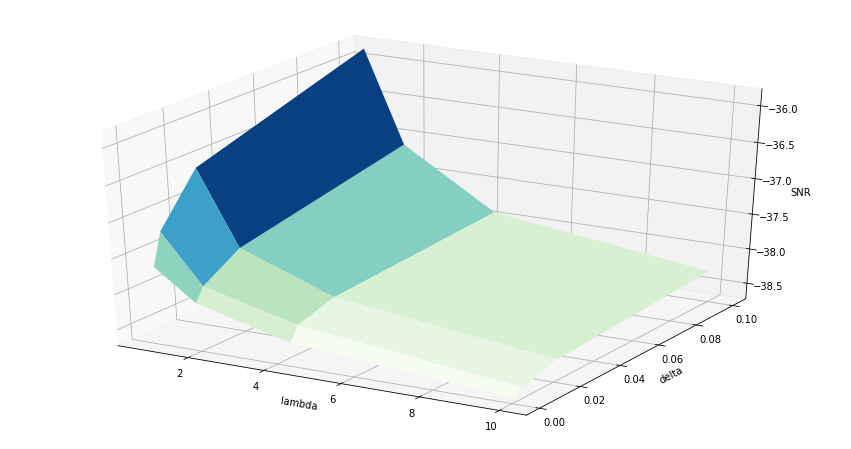

In [417]:
fig = plt.figure(figsize=(15,8))
a = fig.add_subplot(111, projection='3d')

a.plot_surface(X,Y,Z,cmap='GnBu')
a.set_xlabel('lambda')
#a.set_yscale('log')
a.set_ylabel('delta')
a.set_zlabel('SNR')

**Conclusion**: The best parametrisation choice for the regularisation formulation w.r.t to the signal to noise ration is in our exploration $\lambda$ = 10 and $\delta$ = 0.001. This result seems plausible as a bigger regularisation parameter is expected to force the solution to be less noisy. A smaller value of $\delta$ present better results, however, the computational time is highly deteriorated by this setting. Hence, there is a trade-off to chose between precision of the solution and computation time.